<a href="https://colab.research.google.com/github/kareemullah123456789/cybersecurity_ML/blob/main/cyber_workshop_2_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# -------------------------------
# 2. Load and Merge Data
# -------------------------------
import os
base_path = '/content/drive/MyDrive/cybersecurity_data/data'
users = pd.read_csv(os.path.join(base_path,"users.csv"))
devices = pd.read_csv(os.path.join(base_path,"devices.csv"))
traffic = pd.read_csv(os.path.join(base_path,"network_traffic.csv"))

df = traffic.merge(users, on="user_id", how="left")
df = df.merge(devices, on="device_id", how="left")


In [4]:
users.head(2)

,user_id,username,department,role
0,USR_EMP0001,e_gmfht1@company.com,HR,Recruiter
1,USR_EMP0002,e_fdppg2@company.com,Sales,Sales Rep


In [5]:
devices.head(2)

,device_id,device_type,os
0,D0001,Desktop,Ubuntu 22.04
1,D0002,Mobile,Ubuntu 20.04


In [38]:
traffic.head()

,log_id,user_id,device_id,timestamp,src_ip,dst_ip,protocol,port,bytes_sent,bytes_received,duration,is_anomaly
0,T00001,USR_EMP0028,D0403,2022-02-19 08:39:32,192.168.215.198,10.0.241.5,SSH,22.0,6762.0,4230.0,23.31,1
1,T00002,USR_EMP0055,D0282,2022-01-27 01:57:06,192.168.8.133,10.0.126.225,SMTP,25.0,2749.0,521.0,32.80,0
2,T00003,USR_EMP0182,D0298,2022-02-26 07:33:33,192.168.124.236,10.0.129.94,SSH,22.0,5479.0,4067.0,49.70,1
3,T00004,USR_EMP0031,D0229,2022-01-13 17:40:05,192.168.197.6,10.0.3.140,SSH,22.0,3397.0,2030.0,68.11,1
4,T00005,USR_EMP0193,D0179,2022-01-26 17:49:33,192.168.241.180,10.0.237.144,SMTP,25.0,7370.0,5593.0,41.51,0


In [39]:
df.head(2)

,log_id,user_id,device_id,timestamp,src_ip,dst_ip,protocol,port,bytes_sent,bytes_received,duration,is_anomaly,username,department,role,device_type,os
0,T00001,USR_EMP0028,D0403,2022-02-19 08:39:32,192.168.215.198,10.0.241.5,SSH,22.0,6762.0,4230.0,23.31,1,e_tifcs28@company.com,HR,Recruiter,Laptop,Ubuntu 22.04
1,T00002,USR_EMP0055,D0282,2022-01-27 01:57:06,192.168.8.133,10.0.126.225,SMTP,25.0,2749.0,521.0,32.80,0,e_hodhj55@company.com,Marketing,SEO Specialist,Desktop,Ubuntu 20.04


In [6]:
df.columns

Index(['log_id', 'user_id', 'device_id', 'timestamp', 'src_ip', 'dst_ip',
       'protocol', 'port', 'bytes_sent', 'bytes_received', 'duration',
       'is_anomaly', 'username', 'department', 'role', 'device_type', 'os'],
      dtype='object')

In [7]:

# -------------------------------
# 3. Drop unnecessary columns
# -------------------------------
drop_cols = ["log_id", "user_id", "device_id", "username", "src_ip", "dst_ip"]
df = df.drop(columns=drop_cols)
df.columns

Index(['timestamp', 'protocol', 'port', 'bytes_sent', 'bytes_received',
       'duration', 'is_anomaly', 'department', 'role', 'device_type', 'os'],
      dtype='object')

In [8]:

# -------------------------------
# 4. Extract hour from timestamp
# -------------------------------
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["hour"] = df["timestamp"].dt.hour


In [9]:
df["hour"].head()

,hour
0,8
1,1
2,7
3,17
4,17


In [10]:
df.shape

(10000, 12)

In [11]:
df.isnull().sum()

,0
timestamp,0
protocol,78
port,109
bytes_sent,103
bytes_received,118
duration,96
is_anomaly,0
department,449
role,357
device_type,382


In [12]:
# -------------------------------
# 5. Define feature groups
# -------------------------------
num_cols = ["bytes_sent", "bytes_received", "duration", "hour"]
cat_cols = ["protocol", "port", "department", "role", "device_type", "os"]

In [13]:
# 6. Define preprocessing
# -------------------------------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [14]:
df.isnull().sum()

,0
timestamp,0
protocol,78
port,109
bytes_sent,103
bytes_received,118
duration,96
is_anomaly,0
department,449
role,357
device_type,382


In [15]:
# -------------------------------
# 7. Split data
# -------------------------------
X = df.drop(columns=["is_anomaly", "timestamp"])
y = df["is_anomaly"].astype(int).values

In [16]:
X.columns

Index(['protocol', 'port', 'bytes_sent', 'bytes_received', 'duration',
       'department', 'role', 'device_type', 'os', 'hour'],
      dtype='object')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define candidate models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

results = []

# Loop through each model
for name, model in models.items():
    # Build pipeline (preprocessor + classifier)
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    # Train
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf.named_steps["classifier"], "predict_proba") else None

    # Collect metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
print(results_df)


                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
2        Random Forest  0.903667   0.986348  0.503484  0.666667  0.749673
3    Gradient Boosting  0.901667   0.957377  0.508711  0.664391  0.750348
4                  SVM  0.887333   0.950382  0.433798  0.595694  0.751215
1        Decision Tree  0.814333   0.514143  0.538328  0.525957  0.708982
5                  KNN  0.862333   0.792727  0.379791  0.513545  0.717449
0  Logistic Regression  0.814667   0.567164  0.132404  0.214689  0.692193


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Original RF (without class_weight)
rf_default = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=10,
        random_state=42
    ))
])

rf_default.fit(X_train, y_train)
y_pred_default = rf_default.predict(X_test)
y_proba_default = rf_default.predict_proba(X_test)[:, 1]

# Balanced RF (with class_weight="balanced")
rf_balanced = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=10,
        random_state=42,
        class_weight="balanced"
    ))
])

rf_balanced.fit(X_train, y_train)
y_pred_bal = rf_balanced.predict(X_test)
y_proba_bal = rf_balanced.predict_proba(X_test)[:, 1]

# Collect results into DataFrame
comparison = pd.DataFrame([
    {
        "Model": "Random Forest (Default)",
        "Accuracy": accuracy_score(y_test, y_pred_default),
        "Precision": precision_score(y_test, y_pred_default),
        "Recall": recall_score(y_test, y_pred_default),
        "F1": f1_score(y_test, y_pred_default),
        "ROC-AUC": roc_auc_score(y_test, y_proba_default)
    },
    {
        "Model": "Random Forest (Balanced)",
        "Accuracy": accuracy_score(y_test, y_pred_bal),
        "Precision": precision_score(y_test, y_pred_bal),
        "Recall": recall_score(y_test, y_pred_bal),
        "F1": f1_score(y_test, y_pred_bal),
        "ROC-AUC": roc_auc_score(y_test, y_proba_bal)
    }
])

print(comparison)


                      Model  Accuracy  Precision    Recall        F1   ROC-AUC
0   Random Forest (Default)  0.903333   0.982993  0.503484  0.665899  0.743873
1  Random Forest (Balanced)  0.902000   0.954545  0.512195  0.666667  0.746286


   Threshold  Precision    Recall        F1
0        0.1   0.193449  0.987805  0.323538
1        0.2   0.237683  0.764808  0.362660
2        0.3   0.491228  0.585366  0.534181
3        0.4   0.832869  0.520906  0.640943
4        0.5   0.954545  0.512195  0.666667
5        0.6   0.982877  0.500000  0.662818
6        0.7   0.979592  0.418118  0.586081
7        0.8   0.984456  0.331010  0.495437
8        0.9   0.988024  0.287456  0.445344


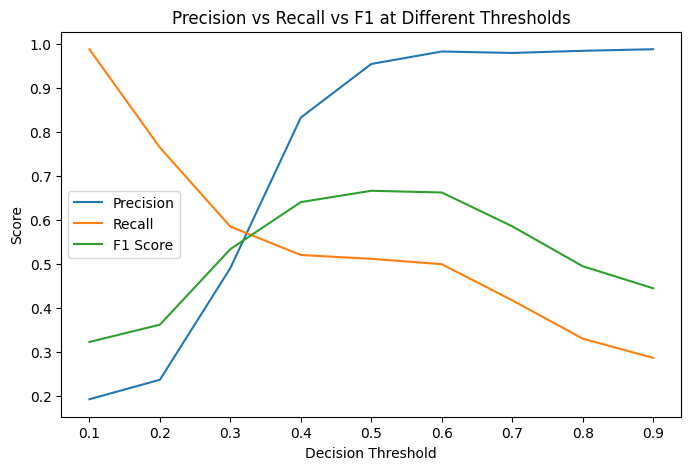

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Use the balanced RF model from before (or default, doesn’t matter)
rf_balanced.fit(X_train, y_train)
y_proba = rf_balanced.predict_proba(X_test)[:, 1]

# Try different thresholds
thresholds = np.linspace(0.1, 0.9, 9)
results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    results.append({
        "Threshold": t,
        "Precision": precision_score(y_test, y_pred_t),
        "Recall": recall_score(y_test, y_pred_t),
        "F1": f1_score(y_test, y_pred_t)
    })

results_df = pd.DataFrame(results)
print(results_df)

# Plot Precision-Recall tradeoff
plt.figure(figsize=(8,5))
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")
plt.plot(results_df["Threshold"], results_df["F1"], label="F1 Score")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall vs F1 at Different Thresholds")
plt.legend()
plt.show()


Threshold 0.1 → The model screams “anomaly” at everything. Recall is almost perfect (0.99), but precision is awful (0.19).

Threshold 0.5 (default) → Balanced: very high precision (0.95) and moderate recall (0.51). F1 is strongest here (0.67).

Threshold 0.7+ → Ultra-strict: the model rarely says anomaly. Precision is great (0.98), but recall collapses (0.29–0.42).

In [21]:
best_idx = results_df["F1"].idxmax()
best_threshold = results_df.loc[best_idx, "Threshold"]
print("Best threshold (by F1):", best_threshold)


Best threshold (by F1): 0.5


In [22]:
import joblib
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, threshold=0.5):
        self.base_model = base_model
        self.threshold = threshold

    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self

    def predict(self, X):
        proba = self.base_model.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.base_model.predict_proba(X)


In [23]:
from sklearn.ensemble import RandomForestClassifier

# Base RF with preprocessing
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=10,
        random_state=42,
        class_weight="balanced"   # optional, depending on choice
    ))
])

# Wrap with threshold
final_model = ThresholdClassifier(base_model=rf_pipeline, threshold=0.3)  # <-- choose threshold here

# Fit on training data
final_model.fit(X_train, y_train)

# Evaluate
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.86      0.88      2426
           1       0.49      0.59      0.53       574

    accuracy                           0.80      3000
   macro avg       0.69      0.72      0.71      3000
weighted avg       0.82      0.80      0.81      3000



In [24]:
joblib.dump(final_model, "cybersecurity_rf_threshold.joblib")
print("Saved as cybersecurity_rf_threshold.joblib")


Saved as cybersecurity_rf_threshold.joblib


In [25]:
from sklearn.model_selection import RandomizedSearchCV

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, class_weight="balanced")) # class_weight optional
])

rf_params = {
    "classifier__n_estimators": [100, 200, 300, 400],
    "classifier__max_depth": [10, 20, 30, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_params,
    n_iter=15,          # how many combos to try
    scoring="f1",       # optimize for F1 (balanced metric)
    cv=3,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)
print("Best RF F1 (CV):", rf_search.best_score_)


Best RF params: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 30}
Best RF F1 (CV): 0.6792039712682794


In [26]:
gb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(random_state=42))
])

gb_params = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__max_depth": [3, 5, 7]
}

gb_search = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=gb_params,
    n_iter=10,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    random_state=42
)

gb_search.fit(X_train, y_train)

print("Best GB params:", gb_search.best_params_)
print("Best GB F1 (CV):", gb_search.best_score_)


Best GB params: {'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05}
Best GB F1 (CV): 0.6798887053492316


In [27]:
from sklearn.metrics import classification_report, roc_auc_score

# Best RF
best_rf = rf_search.best_estimator_
rf_pred = best_rf.predict(X_test)
rf_proba = best_rf.predict_proba(X_test)[:,1]

# Best GB
best_gb = gb_search.best_estimator_
gb_pred = best_gb.predict(X_test)
gb_proba = best_gb.predict_proba(X_test)[:,1]

# Collect results
comparison = pd.DataFrame([
    {
        "Model": "Random Forest (Tuned)",
        "Accuracy": accuracy_score(y_test, rf_pred),
        "Precision": precision_score(y_test, rf_pred),
        "Recall": recall_score(y_test, rf_pred),
        "F1": f1_score(y_test, rf_pred),
        "ROC-AUC": roc_auc_score(y_test, rf_proba)
    },
    {
        "Model": "Gradient Boosting (Tuned)",
        "Accuracy": accuracy_score(y_test, gb_pred),
        "Precision": precision_score(y_test, gb_pred),
        "Recall": recall_score(y_test, gb_pred),
        "F1": f1_score(y_test, gb_pred),
        "ROC-AUC": roc_auc_score(y_test, gb_proba)
    }
])

print(comparison)


                       Model  Accuracy  Precision    Recall        F1  \
0      Random Forest (Tuned)  0.904333   0.979933  0.510453  0.671249   
1  Gradient Boosting (Tuned)  0.902667   0.966887  0.508711  0.666667   

    ROC-AUC  
0  0.746697  
1  0.741841  


Lets go ahead with Random forest

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Get probabilities for anomalies (class=1)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Try thresholds from 0.1 to 0.9
thresholds = np.linspace(0.1, 0.9, 9)
results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    results.append({
        "Threshold": round(t, 2),
        "Precision": precision_score(y_test, y_pred_t, zero_division=0),
        "Recall": recall_score(y_test, y_pred_t, zero_division=0),
        "F1": f1_score(y_test, y_pred_t, zero_division=0)
    })

results_df = pd.DataFrame(results)
print(results_df)


   Threshold  Precision    Recall        F1
0        0.1   0.204465  0.909408  0.333866
1        0.2   0.346471  0.658537  0.454054
2        0.3   0.670354  0.527875  0.590643
3        0.4   0.911043  0.517422  0.660000
4        0.5   0.979933  0.510453  0.671249
5        0.6   0.982079  0.477352  0.642438
6        0.7   0.982979  0.402439  0.571075
7        0.8   0.984293  0.327526  0.491503
8        0.9   0.993711  0.275261  0.431105


In [29]:
# Threshold that maximizes F1
best_idx = results_df["F1"].idxmax()
best_threshold = results_df.loc[best_idx, "Threshold"]
print("Best threshold (by F1):", best_threshold)


Best threshold (by F1): 0.5


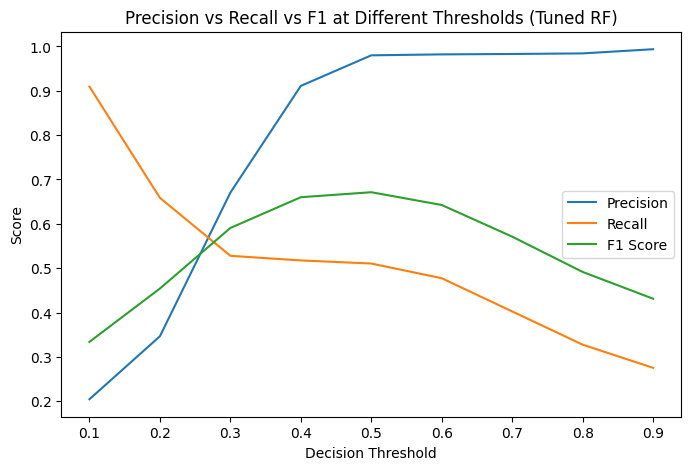

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision")
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall")
plt.plot(results_df["Threshold"], results_df["F1"], label="F1 Score")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall vs F1 at Different Thresholds (Tuned RF)")
plt.legend()
plt.show()


In [31]:
import joblib
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, threshold=0.5):
        self.base_model = base_model
        self.threshold = threshold

    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self

    def predict(self, X):
        proba = self.base_model.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.base_model.predict_proba(X)  # raw probabilities


In [32]:
# Wrap tuned RF with threshold=0.4
final_model = ThresholdClassifier(base_model=best_rf, threshold=0.4)

# Refit (so wrapper learns properly)
final_model.fit(X_train, y_train)

# Test
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2426
           1       0.91      0.52      0.66       574

    accuracy                           0.90      3000
   macro avg       0.90      0.75      0.80      3000
weighted avg       0.90      0.90      0.89      3000



In [33]:
joblib.dump(final_model, "rf_threshold_0_4.joblib")
print("Saved as rf_threshold_0_4.joblib")


Saved as rf_threshold_0_4.joblib


In [70]:
ls

app.py                             drive/                   sample_data/
cybersecurity_rf_threshold.joblib  rf_threshold_0_4.joblib


In [34]:
import joblib

categories = {
    "protocol": df["protocol"].unique().tolist(),
    "port": df["port"].unique().tolist(),
    "department": df["department"].unique().tolist(),
    "role": df["role"].unique().tolist(),
    "device_type": df["device_type"].unique().tolist(),
    "os": df["os"].unique().tolist()
}

joblib.dump(categories, "categories.joblib")
print("Categories saved as categories.joblib")


Categories saved as categories.joblib


In [35]:
!pip install gradio

In [36]:
import gradio as gr
import pandas as pd
import joblib

# Load model
model = joblib.load("rf_threshold_0_4.joblib")

# Example mapping dictionaries (adjust to your dataset!)
protocol_map = {"FTP": 4, "TCP": 5, "UDP": 6}
department_map = {"HR": 0, "Finance": 1, "Engineering": 2, "Sales": 3, "IT": 4}
role_map = {"Analyst": 0, "Manager": 1, "Engineer": 2, "Admin": 3}
device_type_map = {"Laptop": 0, "Server": 1, "Firewall": 2, "Router": 3}
os_map = {"Windows": 0, "Linux": 1, "MacOS": 2, "Other": 3}

def predict(bytes_sent, bytes_received, duration, hour, protocol, port, department, role, device_type, os):
    input_data = pd.DataFrame([{
        "bytes_sent": bytes_sent,
        "bytes_received": bytes_received,
        "duration": duration,
        "hour": hour,
        "protocol": protocol_map[protocol],
        "port": port,
        "department": department_map[department],
        "role": role_map[role],
        "device_type": device_type_map[device_type],
        "os": os_map[os]
    }])

    pred = model.predict(input_data)[0]
    prob = model.predict_proba(input_data)[0][1]
    return ("⚠️ Anomaly" if pred == 1 else "✅ Normal"), float(prob)

demo = gr.Interface(
    fn=predict,
    inputs=[
        gr.Number(label="Bytes Sent"),
        gr.Number(label="Bytes Received"),
        gr.Number(label="Duration (seconds)"),
        gr.Slider(0, 23, step=1, label="Hour"),
        gr.Dropdown(list(protocol_map.keys()), label="Protocol"),
        gr.Number(label="Port"),
        gr.Dropdown(list(department_map.keys()), label="Department"),
        gr.Dropdown(list(role_map.keys()), label="Role"),
        gr.Dropdown(list(device_type_map.keys()), label="Device Type"),
        gr.Dropdown(list(os_map.keys()), label="Operating System")
    ],
    outputs=[gr.Label(label="Prediction"), gr.Number(label="Anomaly Probability")],
    live=False,
    title="🔒 Cybersecurity Anomaly Detection",
    description="Provide session details to predict if traffic is Normal or Anomaly."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ca8b18dc1519d54aa0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
